In [2]:
import ROOT
import uproot
import numpy  as np
import matplotlib.pyplot as plt

In [ ]:
void MatrixUnfControl::FillCorrelationMatrixAllVariables(int nbins, TString namestring, std::vector<std::vector<std::vector<TH1D*>>>hPseudoUnfDeltapull, TH2D* &h_RhoVV, TMatrixD &m_RhoVV){

  double RhoVV[3][nbins][nbins]    = {0};
  double RhoVVerr[3][nbins][nbins] = {0};

  double oneoversumoneoversigmasq=0.;
  double oneoversigmasq[2]={0.};

  h_RhoVV    = new TH2D(Form("h_Rho%s",namestring.Data()), Form("h_Rho%s",namestring.Data()), nbins, 0, nbins, nbins, 0, nbins);

  for(int i=0;i<nbins;i++){
    for(int j=0;j<nbins;j++){
      for(int l=0;l<3;l++){
        if(l<2){
          // sigma^2 = 2 +/- 2*rho_ij => rho_ij = (-/+)(1 - (sigma^2)/2 )
          RhoVV[l][j][i] = (l==0?1.:-1.)*(1.-0.5*pow(hPseudoUnfDeltapull[l][j][i]->GetRMS(),2));  
          RhoVVerr[l][j][i] = hPseudoUnfDeltapull[l][j][i]->GetRMSError()*hPseudoUnfDeltapull[l][j][i]->GetRMS();
        }
        else{
          // combine + and - results by weighted average
          oneoversigmasq[0] = RhoVVerr[0][j][i] > 0 ? pow(RhoVVerr[0][j][i],-2) : 1e100;
          oneoversigmasq[1] = RhoVVerr[1][j][i] > 0 ? pow(RhoVVerr[1][j][i],-2) : 1e100;
          oneoversumoneoversigmasq = 1./(oneoversigmasq[0]+oneoversigmasq[1]);

          RhoVV[2][j][i] = (RhoVV[0][j][i]*oneoversigmasq[0] + RhoVV[1][j][i]*oneoversigmasq[1])*oneoversumoneoversigmasq;
          RhoVVerr[2][j][i] = sqrt(oneoversumoneoversigmasq);

          h_RhoVV->SetBinContent( j+1, i+1, RhoVV[2][j][i] );
          h_RhoVV->SetBinError( j+1, i+1, RhoVVerr[2][j][i] );
          m_RhoVV(j,i) = RhoVV[2][j][i];
        }   
      }
    }
  }
}

In [8]:
nbins    = 6
RhoVV    = np.zeros([3, nbins, nbins])
RhoVVerr = np.zeros([3, nbins, nbins])

oneoversumoneoversigmasq =  0.
oneoversigmasq           = [0.] * 2

In [ ]:
for i in range(nbins) :
    for j in range(nbins) :
        for l in range(3)  :
            if   l == 0 : 
                # sigma^2 = 2 +/- 2*rho_ij => rho_ij = (-/+)(1 - (sigma^2)/2 )
                RhoVV[l][j][i]    =  1. * (1. - 0.5 * pow(hPseudoUnfDeltapull[l][j][i].GetRMS(),2))
                RhoVVerr[l][j][i] = hPseudoUnfDeltapull[l][j][i].GetRMSError() * hPseudoUnfDeltapull[l][j][i].GetRMS()
            
            elif l == 1 : 
                # sigma^2 = 2 +/- 2*rho_ij => rho_ij = (-/+)(1 - (sigma^2)/2 )
                RhoVV[l][j][i]    = -1. * (1. - 0.5 * pow(hPseudoUnfDeltapull[l][j][i].GetRMS(),2))
                RhoVVerr[l][j][i] = hPseudoUnfDeltapull[l][j][i].GetRMSError() * hPseudoUnfDeltapull[l][j][i].GetRMS()
            
            else :  
                # combine + and - results by weighted average 
                oneoversigmasq[0]        = pow(RhoVVerr[0][j][i],-2) if RhoVVerr[0][j][i] > 0 else 1e100 
                oneoversigmasq[1]        = pow(RhoVVerr[1][j][i],-2) if RhoVVerr[1][j][i] > 0 else 1e100
                oneoversumoneoversigmasq = 1./(oneoversigmasq[0] + oneoversigmasq[1]);

                RhoVV[2][j][i]    = (RhoVV[0][j][i] * oneoversigmasq[0] + RhoVV[1][j][i] * oneoversigmasq[1]) *oneoversumoneoversigmasq;
                RhoVVerr[2][j][i] = sqrt(oneoversumoneoversigmasq);

                h_RhoVV.SetBinContent( j+1, i+1, RhoVV[2][j][i]);
                h_RhoVV.SetBinError(j+1, i+1, RhoVVerr[2][j][i]);
                m_RhoVV(j,i) = RhoVV[2][j][i];

In [ ]:
void MatrixUnfControl::calculateCorrelationMatrices(int nVar, int nbinsrhoi, int nPE, bool docorrectpullwidth, TString rebinnedstring, TFile* BootstrapCorrelationMatricesFile, TH1D* hAllVarUnf, TH1D* hist_acombfactor[], std::vector<std::vector<std::vector<float>>> &BinPE, std::vector<std::vector<std::vector<float>>> &CoefPE, std::vector<double> &pullwidthBins, std::vector<double> &pullwidthVBins) {

  const int nbinsrn = nbinsrhoi * nVar;

  std::vector<TString> mnames;
  mnames.push_back("Afb0");
  mnames.push_back("Afb1");
  mnames.push_back("Afb2");
  mnames.push_back("BinSum");
  mnames.push_back("Coef");
  mnames.push_back("Afb");

  // Amandeep : Commenting to experiment
  TString nametag    = docorrectpullwidth ? "Corrected_"+rebinnedstring : "_"+rebinnedstring;
  // TString nametag =  "_" + rebinnedstring;

  if(!docorrectpullwidth) {
    pullwidthBins.clear();
    pullwidthVBins.clear();
  }

  if(docorrectpullwidth) {
    for(int j=0;j<nbinsrn;j++){
      for (int iPE = 0; iPE < nPE; ++iPE)
      {
        BinPE[j%nbinsrhoi][j/nbinsrhoi][iPE]  /= pullwidthBins[j];
        CoefPE[j%nbinsrhoi][j/nbinsrhoi][iPE] /= pullwidthVBins[j];
        // Amandeep : Adding for debugging
        std::cout << "BinPE :: "  << BinPE[j%nbinsrhoi][j/nbinsrhoi][iPE] << std::endl;
        std::cout << "CoefPE :: " << CoefPE[j%nbinsrhoi][j/nbinsrhoi][iPE] << std::endl;
        // End
      }
      hAllVarUnf->SetBinError(j+1, hAllVarUnf->GetBinError(j+1)*pullwidthBins[j]);
    }
  }

  // Create and fill histograms for the bootstrap ensemble results
  std::vector<std::vector<std::vector<std::vector<TH1D*>>>> hPseudoUnfDeltapull(nbinsrhoi, std::vector<std::vector<std::vector<TH1D*>>>(2, std::vector<std::vector<TH1D*>>(nbinsrn, std::vector<TH1D*>(nbinsrn))));
  std::vector<std::vector<std::vector<TH1D*>>> hPseudoUnfDeltapullBins(2, std::vector<std::vector<TH1D*>>(nbinsrn, std::vector<TH1D*>(nbinsrn)));
  std::vector<std::vector<std::vector<TH1D*>>> hPseudoUnfDeltapullVBins(2, std::vector<std::vector<TH1D*>>(nbinsrn, std::vector<TH1D*>(nbinsrn)));

  // Also directly calculate Pearson correlation coefficients for comparison with the 'FillCorrelationMatrixAllVariables' method. 
  // The results are basically the same, but prefer the 'FillCorrelationMatrixAllVariables' method because it also returns an estimate of the uncertainty (and also seems to be slightly more precise).
  std::vector<std::vector<std::vector<std::vector<double>>>> rPearson(nbinsrhoi, std::vector<std::vector<std::vector<double>>>(2, std::vector<std::vector<double>>(nbinsrn, std::vector<double>(nbinsrn))));
  std::vector<std::vector<std::vector<double>>> rPearsonBins(2, std::vector<std::vector<double>>(nbinsrn, std::vector<double>(nbinsrn)));
  std::vector<std::vector<std::vector<double>>> rPearsonVBins(2, std::vector<std::vector<double>>(nbinsrn, std::vector<double>(nbinsrn)));


  double nsigmas = 10.;

  for(int k=0; k < nbinsrhoi; k++){ // Over the bins
    for(int i=0; i < nVar; i++)  {  // Over the variables
      for(int j=0; j < nVar; j++) { // Over the variables
        for(int l=0; l < 2; l++)   {// +/- 1 sigma

          // Amandeep : Adding for debugging 
          std::cout << "Name :: " << Form("hPseudoUnfDeltapull%s%s_%s_%s_%s",nametag.Data(), l>0?"Plus":"Minus", mnames[k].Data(), fVariableNames[j].Data(), fVariableNames[i].Data()) << std::endl;
          // End
          hPseudoUnfDeltapull[k][l][j][i] = new TH1D(Form("hPseudoUnfDeltapull%s%s_%s_%s_%s",nametag.Data(), l>0?"Plus":"Minus", mnames[k].Data(), fVariableNames[j].Data(), fVariableNames[i].Data()), Form("hPseudoUnfDeltapull%s%s_%s_%s_%s",nametag.Data(), l>0?"Plus":"Minus", mnames[k].Data(), fVariableNames[j].Data(), fVariableNames[i].Data()), 200, -nsigmas, nsigmas);

          for (int iPE = 0; iPE < nPE; ++iPE)
          {
            hPseudoUnfDeltapull[k][l][j][i]->Fill(CoefPE[k][j][iPE] + (l==0?-1.:1.)*CoefPE[k][i][iPE]);
            rPearson[k][l][j][i] += (CoefPE[k][j][iPE]*(l==0?-1.:1.)*CoefPE[k][i][iPE]);
          }
          rPearson[k][l][j][i] /= nPE;
          // Amandeep : Adding for debugging
          if(l==1 && k==4) std::cout << "rPearson :: " << i+1 << " " << j+1 << " " << rPearson[k][l][j][i] << std::endl;
          // End
        }
      }
    }
  }

  for(int i=0; i < nbinsrn; i++){
    for(int j=0; j < nbinsrn; j++){
      for(int l=0; l < 2; l++){
        
        // Amandeep : Adding for debugging
        std::cout << "Var names :: " << fVariableNames[j/nbinsrhoi].Data() << " " << fVariableNames[i/nbinsrhoi].Data() << std::endl; 
        std::cout << "Name :: " << Form("hPseudoUnfDeltapullBins%s%s_%s%d_%s%d" ,nametag.Data(), l>0?"Plus":"Minus", fVariableNames[j/nbinsrhoi].Data(), j%nbinsrhoi, fVariableNames[i/nbinsrhoi].Data(), i%nbinsrhoi) << std::endl;
        // End

        hPseudoUnfDeltapullBins[l][j][i]  = new TH1D(Form("hPseudoUnfDeltapullBins%s%s_%s%d_%s%d" ,nametag.Data(), l>0?"Plus":"Minus", fVariableNames[j/nbinsrhoi].Data(), j%nbinsrhoi, fVariableNames[i/nbinsrhoi].Data(), i%nbinsrhoi), Form("hPseudoUnfDeltapullBins%s%s_%s%d_%s%d" , nametag.Data(), l>0?"Plus":"Minus", fVariableNames[j/nbinsrhoi].Data(), j%nbinsrhoi, fVariableNames[i/nbinsrhoi].Data(),i%nbinsrhoi), 200, -nsigmas, nsigmas);
        hPseudoUnfDeltapullVBins[l][j][i] = new TH1D(Form("hPseudoUnfDeltapullVBins%s%s_%s%d_%s%d",nametag.Data(), l>0?"Plus":"Minus", fVariableNames[j/nbinsrhoi].Data(), j%nbinsrhoi, fVariableNames[i/nbinsrhoi].Data(), i%nbinsrhoi), Form("hPseudoUnfDeltapullVBins%s%s_%s%d_%s%d", nametag.Data(), l>0?"Plus":"Minus", fVariableNames[j/nbinsrhoi].Data(), j%nbinsrhoi, fVariableNames[i/nbinsrhoi].Data(),i%nbinsrhoi), 200, -nsigmas, nsigmas);

        for (int iPE = 0; iPE < nPE; ++iPE)
        {
          hPseudoUnfDeltapullBins[l][j][i]->Fill(BinPE[j%nbinsrhoi][j/nbinsrhoi][iPE] + (l==0?-1.:1.)*BinPE[i%nbinsrhoi][i/nbinsrhoi][iPE]);
          hPseudoUnfDeltapullVBins[l][j][i]->Fill(CoefPE[j%nbinsrhoi][j/nbinsrhoi][iPE] + (l==0?-1.:1.)*CoefPE[i%nbinsrhoi][i/nbinsrhoi][iPE]);
          rPearsonBins[l][j][i] += (BinPE[j%nbinsrhoi][j/nbinsrhoi][iPE] *(l==0?-1.:1.)*BinPE[i%nbinsrhoi][i/nbinsrhoi][iPE]);
          rPearsonVBins[l][j][i]+= (CoefPE[j%nbinsrhoi][j/nbinsrhoi][iPE]*(l==0?-1.:1.)*CoefPE[i%nbinsrhoi][i/nbinsrhoi][iPE]);
        }
        rPearsonBins[l][j][i] /= nPE;
        rPearsonVBins[l][j][i]/= nPE;

        // Amandeep : adding for experimentation
        std::cout << "rPearsonBins :: "  << rPearsonBins[l][j][i]  << std::endl;
        std::cout << "rPearsonVBins :: " << rPearsonVBins[l][j][i] << std::endl;
        // End
      }
    }

    if(!docorrectpullwidth) {
      pullwidthBins.push_back(hPseudoUnfDeltapullBins[1][i][i]->GetRMS()/2.);
      pullwidthVBins.push_back(hPseudoUnfDeltapullVBins[1][i][i]->GetRMS()/2.);
    }
  }


  BootstrapCorrelationMatricesFile->cd();
  
  TH2D* h_RhoVV[nbinsrhoi];

  for (int k = 0; k < nbinsrhoi; ++k)
  {
    TMatrixD m_RhoVV(nVar,nVar);
    MatrixUnfControl::FillCorrelationMatrixAllVariables(nVar, Form("VV%s_%s",nametag.Data(), mnames[k].Data()), hPseudoUnfDeltapull.at(k), h_RhoVV[k], m_RhoVV);
  }
  std::cout << "Pearson (above)" << std::endl;
  std::cout << "DeltaPullWidth (below):" << std::endl;
  for(int i=0; i < nVar ;i++){
    for(int j=0; j < nVar; j++){
      std::cout << i+1 << " " << j+1 << " " << h_RhoVV[4]->GetBinContent(j+1,i+1)<< std::endl;
    }
  }

  TH2D* h_RhoBB;
  TMatrixD m_RhoBB(nbinsrn,nbinsrn);
  MatrixUnfControl::FillCorrelationMatrixAllVariables(nbinsrn, Form("BB%s",nametag.Data()), hPseudoUnfDeltapullBins, h_RhoBB, m_RhoBB);

  TH2D* h_RhoVBVB;
  TMatrixD m_RhoVBVB(nbinsrn,nbinsrn);
  MatrixUnfControl::FillCorrelationMatrixAllVariables(nbinsrn, Form("VBVB%s",nametag.Data()), hPseudoUnfDeltapullVBins, h_RhoVBVB, m_RhoVBVB);

  // Cross-check that we get the same (to first order) correlation matrix for each of the measured variables 
  // when we calculate it starting from the correlation matrix for all the measured bins, m_RhoBB

  TMatrixD m_AFB(nVar,nVar);
  std::vector<double> afbvar;
  std::vector<double> afberrvar;
  MatrixUnf::GetAfbCorrMAllVars(hAllVarUnf, m_RhoBB, afbvar, afberrvar, m_AFB);

  TH2D* h_RhoAA = new TH2D(Form("h_RhoAA%s",nametag.Data()), Form("h_RhoAA%s",nametag.Data()), nVar, 0, nVar, nVar, 0, nVar);
  for(int i=0; i < nVar; i++){
    for(int j=0; j < nVar; j++){
      h_RhoAA->SetBinContent( j+1, i+1, m_AFB(j,i) );
    }
  }

  TMatrixD m_BinSum(nVar,nVar);
  std::vector<double> binsum;
  std::vector<double> binsumerr;
  MatrixUnf::GetBinSumCorrMAllVars(hAllVarUnf, m_RhoBB, binsum, binsumerr, m_BinSum);

  TH2D* h_RhoBSBS = new TH2D(Form("h_RhoBSBS%s",nametag.Data()), Form("h_RhoBSBS%s",nametag.Data()), nVar, 0, nVar, nVar, 0, nVar);
  for(int i=0; i < nVar; i++){
    for(int j=0; j < nVar; j++){
      h_RhoBSBS->SetBinContent( j+1, i+1, m_BinSum(j,i) );
    }
  }

  TMatrixD m_AFBB(nVar*nbinsrhoi/2,nVar*nbinsrhoi/2);
  TMatrixD m_C(nVar,nVar);
  std::vector<std::vector<double>> afbvecvec;
  std::vector<std::vector<double>> afberrvecvec;
  MatrixUnf::GetAfbBinsCorrMAllVars(hAllVarUnf, m_RhoBB, afbvecvec, afberrvecvec, m_AFBB, hist_acombfactor, m_C);

  TH2D* h_RhoCC = new TH2D(Form("h_RhoCC%s",nametag.Data()), Form("h_RhoCC%s",nametag.Data()), nVar, 0, nVar, nVar, 0, nVar);
  for(int i=0; i < nVar; i++){
    for(int j=0; j < nVar; j++){
      h_RhoCC->SetBinContent( j+1, i+1, m_C(j,i) );
    }
  }

  TH2D* h_RhoABAB = new TH2D(Form("h_RhoABAB%s",nametag.Data()), Form("h_RhoABAB%s",nametag.Data()), nVar*nbinsrhoi/2, 0, nVar*nbinsrhoi/2, nVar*nbinsrhoi/2, 0, nVar*nbinsrhoi/2);
  for(int i=0; i < nVar*nbinsrhoi/2; i++){
    for(int j=0; j < nVar*nbinsrhoi/2; j++){
      h_RhoABAB->SetBinContent( j+1, i+1, m_AFBB(j,i) );
    }
  }

  TH2D* h_RhoAiAi[nbinsrhoi/2];
  for(int k=0;k<nbinsrhoi/2;k++){
    h_RhoAiAi[k] = new TH2D(Form("h_RhoA%dA%d%s",k,k,nametag.Data()), Form("h_RhoA%dA%d%s",k,k,nametag.Data()), nVar, 0, nVar, nVar, 0, nVar);
    for(int i=0; i < nVar; i++){
      for(int j=0; j < nVar; j++){
        h_RhoAiAi[k]->SetBinContent( j+1, i+1, m_AFBB(j*nbinsrhoi/2+k,i*nbinsrhoi/2+k) );
      }
    }
  }
}


In [11]:
pull_fileptr = uproot.open('/scratch/brown/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/TUnfoldResults_2017/Nominal/combined/Bootstrap_deltapull_histos.root')

In [14]:
[k for k in pull_fileptr.keys() if 'Unf' in k]

['hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b1k_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b1k_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b2k_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b2k_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b1r_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b1r_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b2r_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b2r_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b1n_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b1n_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b2n_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b2n_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b1j_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b1j_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b2j_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b2j_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_Afb0_b1q_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAPlus_Afb0_b1q_b1k;1',
 'hPseudoUnfDeltapull_rebinnedAMinus_

In [41]:
var_fileptr = uproot.open('/scratch/brown/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/TUnfoldResults_2016/Nominal/combined/b1k.root')

In [42]:
var_fileptr.keys()

['b1kScanOfRhoAvg1;1',
 'b1k 0 ScanOfAFBerr1;1',
 'b1k 0 ScanOfCerr1;1',
 'b1k 0 ScanOfCerrOpt1;1',
 'b1k 0 ScanOfa0_1;1',
 'b1k 0 ScanOfa1_1;1',
 'b1k 0 ScanOfa2_1;1',
 'b1k 0 ScanOfCerr0_1;1',
 'b1k 0 ScanOfCerr1_1;1',
 'b1k 0 ScanOfCerr2_1;1',
 'b1k ScanOfRhoAvg2;1',
 'b1kScanOfRhoAvg1_rebinnedB;1',
 'b1kScanOfRhoAvg2_rebinnedB;1',
 'b1kRhoAvg;1',
 'b1kRhoAvg_rebinnedB;1',
 'b1kGen_norm;2',
 'b1kGen_norm;1',
 'b1kRespMat_norm;2',
 'b1kRespMat_norm;1',
 'b1kVisGen_norm;2',
 'b1kVisGen_norm;1',
 'b1kReco_norm;3',
 'b1kReco_norm;2',
 'b1kReco_norm;1',
 'b1kRecoBg_UnfoldingHistos_2016preVFP/Nominal/ee/histosTUnfold_ee_wwtoall_2016ULpreVFP.root;1',
 'b1kRecoBg_UnfoldingHistos_2016preVFP/Nominal/emu/histosTUnfold_emu_wwtoall_2016ULpreVFP.root;1',
 'b1kRecoBg_UnfoldingHistos_2016preVFP/Nominal/mumu/histosTUnfold_mumu_wwtoall_2016ULpreVFP.root;1',
 'b1kRecoBg_UnfoldingHistos_2016postVFP/Nominal/ee/histosTUnfold_ee_wwtoall_2016ULpostVFP.root;1',
 'b1kRecoBg_UnfoldingHistos_2016postVFP/Nomina

In [53]:
unfolded_central = var_fileptr['b1k_pseudo_centralvalueTUnfResult_rebinnedA'].values()
unfolded_toy1    = var_fileptr['b1k_pseudo0TUnfResult_rebinnedA'].values()

In [54]:
unfolded_toy1

array([322727.15382965, 322992.2234673 , 322609.77018141, 323595.3476084 ,
       325130.40276865, 325756.99662347])

In [55]:
unfolded_central

array([322420.68576431, 323500.96326237, 323486.06418318, 324369.0367717 ,
       324713.24659044, 324929.8757216 ])

In [56]:
diff = unfolded_toy1 - unfolded_central
diff

array([ 306.46806534, -508.73979507, -876.29400177, -773.68916329,
        417.15617822,  827.12090187])

In [57]:
sigma_PE = np.sqrt(var_fileptr['b1k_pseudo0TUnfResult_rebinnedA'].to_hist().variances())

In [58]:
diff/sigma_PE

array([ 0.4261664 , -0.86632995, -1.25038995, -1.06945001,  0.43566453,
        0.95433212])

### Compute pulls yourself

In [61]:
pulls = []

unfolded_central = var_fileptr['b1k_pseudo_centralvalueTUnfResult_rebinnedA'].values()

for i in range(1000) : 
    unfolded_toy_bins = var_fileptr['b1k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
    unfolded_toy_err  = np.sqrt(var_fileptr['b1k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].variances())
    
    unfolded_toy_pull = (( unfolded_toy_bins - unfolded_central) / unfolded_toy_err)
    pulls.append(unfolded_toy_pull)

In [63]:
pulls = np.array(pulls)

In [68]:
np.mean(pulls, axis=0)

array([ 0.01901748, -0.02068254, -0.06180646,  0.0067051 ,  0.06700127,
       -0.03138131])

### Compare to pull from unfolded toys

In [69]:
var_fileptr['hPseudoUnfrebinnedAPulls_b1k'].values()

array([ 0.01901748, -0.02068254, -0.06180646,  0.0067051 ,  0.06700127,
       -0.03138131])

### Try and compute covariance yourself

In [ ]:
#                   nsum(xy) - sum(x)sum(y)
# r = --------------------------------------------------------
#      sqrt([n(sum(x^2) - sum(x)^2)] [n(sum(y^2) - sum(y)^2)])

In [72]:
var_fileptr_1 = uproot.open('/scratch/brown/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/TUnfoldResults_2016/Nominal/combined/b1k.root')
var_fileptr_2 = uproot.open('/scratch/brown/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/TUnfoldResults_2016/Nominal/combined/b2k.root')

### Let us try the diagonal of the interior matrix
### i.e bins (0,6) (1,7) (2,8) ... this doesn't really require  2 loops

In [86]:
# x 
x = np.zeros(6)
for i in range(1000) :
    x += var_fileptr_1['b1k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
x

array([3.22434854e+08, 3.23488969e+08, 3.23442867e+08, 3.24373993e+08,
       3.24777488e+08, 3.24902967e+08])

In [87]:
# y 
y = np.zeros(6)
for i in range(1000) :
    y += var_fileptr_2['b2k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
y

array([3.22480831e+08, 3.22873302e+08, 3.23742728e+08, 3.24348968e+08,
       3.24781483e+08, 3.25187645e+08])

In [88]:
# xy 
xy = np.zeros(6)
for i in range(1000) :
    xy += var_fileptr_1['b1k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values() * var_fileptr_2['b2k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
xy

array([1.03979056e+14, 1.04445963e+14, 1.04712257e+14, 1.05210382e+14,
       1.05481695e+14, 1.05654430e+14])

In [89]:
# x^2 
x2 = np.zeros(6)
for i in range(1000) :
    x2 += (var_fileptr_1['b1k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values() ** 2)
x2

array([1.03964764e+14, 1.04645449e+14, 1.04615787e+14, 1.05219004e+14,
       1.05481330e+14, 1.05562711e+14])

In [91]:
# y^2 
y2 = np.zeros(6)
for i in range(1000) :
    y2 += (var_fileptr_2['b2k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values() ** 2)
y2

array([1.03994373e+14, 1.04247510e+14, 1.04809829e+14, 1.05202768e+14,
       1.05483953e+14, 1.05747801e+14])

In [113]:
#                   nsum(xy) - sum(x)sum(y)
# r = --------------------------------------------------------
#      sqrt([n(sum(x^2) - sum(x)^2)] [n(sum(y^2) - sum(y)^2)])

In [97]:
N = xy * 1000 - x * y
N 

array([-3.83222698e+09,  1.11772442e+10, -1.88999845e+10,  1.24275930e+10,
       -1.87380112e+10, -6.24779008e+08])

In [101]:
D1 = (1000 * x2 - (x**2))
D1

array([5.28947676e+11, 3.36211623e+11, 4.98825794e+11, 5.17211264e+11,
       9.13200449e+11, 7.72702469e+11])

In [102]:
D2 = (1000 * y2 - (y**2))
D2

array([4.86435409e+11, 3.41458022e+11, 4.74959892e+11, 5.14893176e+11,
       9.40940762e+11, 7.96893368e+11])

In [104]:
D = np.sqrt(D1 * D2)
D

array([5.07246369e+11, 3.38824668e+11, 4.86746593e+11, 5.16050918e+11,
       9.26966842e+11, 7.84704704e+11])

In [116]:
from_calc = N/D
from_calc

array([-0.00755496,  0.03298828, -0.03882921,  0.02408211, -0.02021433,
       -0.0007962 ])

In [107]:
Bootstrap_matrix_2016_UL = uproot.open('/scratch/brown/bakshi3/TopSpinCorr_Run2_generalized_ND/CMSSW_10_6_30/src/TopAnalysis/Configuration/analysis/diLeptonic/BootstrapCorrelationMatrices_from_own_sample.root')

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fe63b763730>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fe63b763a30>, text=[])

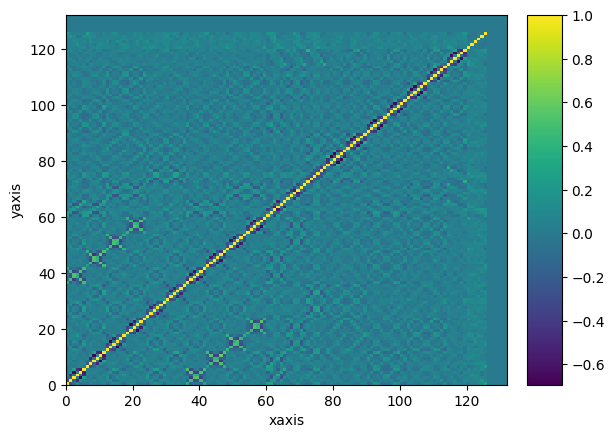

In [108]:
Bootstrap_matrix_2016_UL['h_RhoBBCorrected_rebinnedA'].to_hist().plot()

In [110]:
Bootstrap_matrix_2016_UL['h_RhoBBCorrected_rebinnedA'].to_numpy()[0]

array([[ 1.        , -0.30669905, -0.08427417, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30669905,  1.        , -0.1908177 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08427417, -0.1908177 ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [114]:
from_matrix = []
for i in range(0, 6) :
    from_matrix.append(Bootstrap_matrix_2016_UL['h_RhoBBCorrected_rebinnedA'].to_numpy()[0][i][i+6])

In [115]:
from_matrix = np.array(from_matrix)

In [118]:
100 * ((from_matrix - from_calc) / from_matrix)

array([ 0.97651708, -0.11317575, -0.04887218,  0.17965033, -0.02077622,
        2.25607696])

In [142]:
Bootstrap_matrix_2016_UL['h_RhoBBCorrected_rebinnedA'].to_numpy()[0]

array([[ 1.        , -0.30669905, -0.08427417, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30669905,  1.        , -0.1908177 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08427417, -0.1908177 ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [151]:
BSM = Bootstrap_matrix_2016_UL['h_RhoBBCorrected_rebinnedA'].to_numpy()[0]
BSM[np.ix_([6,7,8,9,10,11],[0,1,2,3,4,5])]

array([[-0.00762946,  0.02965579, -0.00298486,  0.03864836,  0.06243139,
         0.01811037],
       [ 0.08543694,  0.03295099,  0.03380386,  0.03120715,  0.03902938,
         0.06604601],
       [ 0.01688721,  0.08229401, -0.03881024,  0.00548391,  0.06880592,
         0.01587552],
       [-0.00596774,  0.00445359,  0.05549018,  0.02412545,  0.02357117,
         0.02200261],
       [ 0.04013977,  0.03836059,  0.07485122,  0.00592353, -0.02021013,
         0.04731673],
       [ 0.0818633 ,  0.05461855,  0.02281086,  0.08552131, -0.00237739,
        -0.00081457]])

In [144]:
Y = np.arange(16).reshape(4,4)
Y

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [148]:
Y[np.ix_([0,1,2],[0,1,2])]

array([[ 0,  1,  2],
       [ 4,  5,  6],
       [ 8,  9, 10]])

In [175]:
X = var_fileptr_1['b1k_pseudo0TUnfResult_rebinnedA'].values()
X

array([322727.15382965, 322992.2234673 , 322609.77018141, 323595.3476084 ,
       325130.40276865, 325756.99662347])

In [176]:
mu_x = var_fileptr_1['b1k_pseudo_centralvalueTUnfResult_rebinnedA'].values()
mu_x

array([322420.68576431, 323500.96326237, 323486.06418318, 324369.0367717 ,
       324713.24659044, 324929.8757216 ])

In [177]:
X - mu_x

array([ 306.46806534, -508.73979507, -876.29400177, -773.68916329,
        417.15617822,  827.12090187])

In [178]:
Y = var_fileptr_2['b2k_pseudo0TUnfResult_rebinnedA'].values()
Y

array([322109.49857919, 323333.42912286, 322852.42989588, 324226.90101274,
       325256.08619346, 324691.32997435])

In [179]:
mu_y = var_fileptr_2['b2k_pseudo_centralvalueTUnfResult_rebinnedA'].values()
mu_y

array([322475.59907245, 322887.88430807, 323762.80331987, 324323.34255021,
       324720.92538472, 325249.41465952])

In [180]:
Y - mu_y

array([-366.10049326,  445.5448148 , -910.37342399,  -96.44153748,
        535.16080874, -558.08468517])

In [184]:
np.transpose((Y - mu_y))

array([-366.10049326,  445.5448148 , -910.37342399,  -96.44153748,
        535.16080874, -558.08468517])

In [186]:
np.outer((X - mu_x), (Y-mu_y))

array([[-112198.10988989,  136545.25741245, -279000.3819853 ,
         -29556.25140936,  164009.69769932, -171035.13376078],
       [ 186249.88991687, -226666.37777319,  463143.18915465,
          49063.64801288, -272257.60016613,  283919.88836644],
       [ 320811.66629027, -390428.24872461,  797754.77080823,
          84511.14081365, -468958.2066785 ,  489046.26209678],
       [ 283247.98431267, -344713.19496815,  704346.05268625,
          74615.77243819, -414048.11833865,  431784.07311793],
       [-152721.082613  ,  185861.77216502, -379767.89830107,
         -40231.18319595,  223245.63770506, -232808.4743891 ],
       [-302809.37016166,  368519.42903676, -752988.88748432,
         -79768.81145672,  442642.69076791, -461603.5081201 ]])

In [168]:
np.outer((X - mu_x), (Y-mu_y))

array([[-112198.10988989,  136545.25741245, -279000.3819853 ,
         -29556.25140936,  164009.69769932, -171035.13376078],
       [ 186249.88991687, -226666.37777319,  463143.18915465,
          49063.64801288, -272257.60016613,  283919.88836644],
       [ 320811.66629027, -390428.24872461,  797754.77080823,
          84511.14081365, -468958.2066785 ,  489046.26209678],
       [ 283247.98431267, -344713.19496815,  704346.05268625,
          74615.77243819, -414048.11833865,  431784.07311793],
       [-152721.082613  ,  185861.77216502, -379767.89830107,
         -40231.18319595,  223245.63770506, -232808.4743891 ],
       [-302809.37016166,  368519.42903676, -752988.88748432,
         -79768.81145672,  442642.69076791, -461603.5081201 ]])

In [205]:
# mu_x = var_fileptr_1['b1k_pseudo_centralvalueTUnfResult_rebinnedA'].values()
# mu_y = var_fileptr_2['b2k_pseudo_centralvalueTUnfResult_rebinnedA'].values()

mu_x = np.zeros(6)

for i in range(1000) :
    X     = var_fileptr_1['b1k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
    mu_x += X
mu_x /= 1000

mu_y = np.zeros(6)

for i in range(1000) :
    Y     = var_fileptr_2['b2k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
    mu_y += Y
mu_y /= 1000

In [252]:
maybe_cov = np.zeros((6,6))

for i in range(1000) :
    X = var_fileptr_1['b1k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
    Y = var_fileptr_2['b2k_pseudo' + str(i) + 'TUnfResult_rebinnedA'].values()
    
    maybe_cov += np.outer((X - mu_x), (Y-mu_y))

In [253]:
maybe_cov = maybe_cov/1000
maybe_cov

array([[ -3832.22724502,  36297.19799477,   8471.01760748,
         -3122.26656204,  28307.36016666,  53181.81698559],
       [ 11979.26171242,  11177.24424112,  32874.46856419,
          1855.56995585,  21586.42547031,  28271.40380679],
       [ -1466.99528352,  13946.08486468, -18899.98462129,
         28119.26178866,  51294.19269068,  14367.06373856],
       [ 19364.61274795,  13119.07021804,   2711.56039576,
         12427.59292879,   4137.33600854,  54919.35698348],
       [ 41626.27567273,  21807.01942119,  45307.63064714,
         16166.37130787, -18738.0113208 ,  -2034.59759273],
       [ 11087.84700465,  33916.8403923 ,   9633.88160726,
         13883.98368255,  40358.81981899,   -624.77934808]])

In [254]:
sigma = np.sqrt(np.diag(abs(maybe_cov)))
sigma

array([ 61.90498562, 105.72248692, 137.47721492, 111.47911432,
       136.88685591,  24.99558657])

In [255]:
diag_sigma = np.zeros((6,6))

for i in range(6) :
    diag_sigma[i][i] = sigma[i]

In [256]:
np.linalg.inv(diag_sigma) * maybe_cov * np.linalg.inv(diag_sigma)

array([[-1.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0., -1.]])

In [257]:
np.linalg.inv(diag_sigma)

array([[0.01615379, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00945873, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00727393, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.00897029, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0073053 ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04000706]])

In [258]:
maybe_cov

array([[ -3832.22724502,  36297.19799477,   8471.01760748,
         -3122.26656204,  28307.36016666,  53181.81698559],
       [ 11979.26171242,  11177.24424112,  32874.46856419,
          1855.56995585,  21586.42547031,  28271.40380679],
       [ -1466.99528352,  13946.08486468, -18899.98462129,
         28119.26178866,  51294.19269068,  14367.06373856],
       [ 19364.61274795,  13119.07021804,   2711.56039576,
         12427.59292879,   4137.33600854,  54919.35698348],
       [ 41626.27567273,  21807.01942119,  45307.63064714,
         16166.37130787, -18738.0113208 ,  -2034.59759273],
       [ 11087.84700465,  33916.8403923 ,   9633.88160726,
         13883.98368255,  40358.81981899,   -624.77934808]])